In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
DATA_DIR='/home/HDD6TB/datasets/emotions/EmotiW/AFEW/'
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

In [3]:
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from collections import defaultdict
import os
import random
import numpy as np
from tqdm import tqdm
import time
import pickle

In [4]:
import tensorflow
import pathlib
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout, Flatten, LSTM, Activation, MaxPooling2D
from tensorflow.keras.regularizers import l2 as L2_reg
from tensorflow.keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D, Input, Masking, Conv3D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.optimizers import SGD, Adam

print(tf.__version__)

2.4.1


In [5]:
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

1. copy /home/kdemochkin/emotions/train/Angry
        /home/kdemochkin/emotions/train/Disgust
        /home/kdemochkin/emotions/train/Fear
        /home/kdemochkin/emotions/train/Happy
        /home/kdemochkin/emotions/train/Neutral
        /home/kdemochkin/emotions/train/Sad
        /home/kdemochkin/emotions/train/Surprise
        to the features/train_data folder
        
2. copy /home/kdemochkin/emotions/val/Angry
        /home/kdemochkin/emotions/val/Disgust
        /home/kdemochkin/emotions/val/Fear
        /home/kdemochkin/emotions/val/Happy
        /home/kdemochkin/emotions/val/Neutral
        /home/kdemochkin/emotions/val/Sad
        /home/kdemochkin/emotions/val/Surprise
        to the features/val_data folder

# Feature extraction

## Extract frames

In [ ]:
for emotion in ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']:
    for filename in os.listdir('/home/kdemochkin/emotions/train/' + emotion):
        if not os.path.exists('/home/kdemochkin/emotions/train/AlignedFaces_LBPTOP_Points/frames/' + str(os.path.splitext(filename)[0])):
            os.mkdir('/home/kdemochkin/emotions/train/AlignedFaces_LBPTOP_Points/frames/' + str(os.path.splitext(filename)[0]))
        command = "ffmpeg -r 1 -i /home/kdemochkin/emotions/train/" + emotion + str(filename) + " -r 1 '/home/kdemochkin/emotions/train/AlignedFaces_LBPTOP_Points/frames/" + str(os.path.splitext(filename)[0]) + "/%03d.png'"
        os.system(command=command)

## Detect faces in frames

#### MTCNN

In [6]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

/home/HDD6TB/avsavchenko/src/face-emotion-recognition/src/facial_analysis.py:152: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


In [4]:
INPUT_SIZE = (224,224)
def save_faces(source_path,save_path):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.mkdir(os.path.join(save_path, folder))

            for image in os.listdir(os.path.join(source_path, folder)):
                filename = os.path.join(source_path, folder, image)
                frame_bgr = cv2.imread(filename)
                frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                bounding_boxes, _ = imgProcessing.detect_faces(frame)

                if len(bounding_boxes)==0:
                    print('No faces found for ',filename)
                    face_img = frame_bgr
                    faceFound='noface'
                else:
                    if len(bounding_boxes)>1:
                        print('Too many faces (',len(bounding_boxes),') found for ',filename)
                        bounding_boxes=bounding_boxes[:1]

                    b=[int(bi) for bi in bounding_boxes[0]]
                    x1,y1,x2,y2=b[0:4]
                    face_img=frame_bgr[y1:y2,x1:x2,:]

                    if np.prod(face_img.shape)==0:
                        print('Empty face ',b,' found for ',filename)
                        continue
                    
                    faceFound=''

                #face_img=cv2.resize(face_img,INPUT_SIZE)
                root,ext=os.path.splitext(image)
                cv2.imwrite(os.path.join(save_path, folder, root+faceFound+ext), face_img) 
        else:
            print(folder)
        
#source_path = "/home/kdemochkin/emotions/train/AlignedFaces_LBPTOP_Points/frames/"
#save_path = "/home/kdemochkin/emotions/train/AlignedFaces_LBPTOP_Points/frames_mtcnn/"
save_faces(os.path.join(DATA_DIR,'val/AlignedFaces_LBPTOP_Points_Val/frames/'),os.path.join(DATA_DIR,'val/AlignedFaces_LBPTOP_Points_Val/frames_mtcnn_cropped/'))
save_faces(os.path.join(DATA_DIR,'train/AlignedFaces_LBPTOP_Points/frames/'),os.path.join(DATA_DIR,'train/AlignedFaces_LBPTOP_Points/frames_mtcnn_cropped/'))


#### Aligned

In [7]:
import numpy as np
import cv2
import math
from skimage import transform as trans
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

#print(get_iou([10,10,20,20],[15,15,25,25]))

def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped


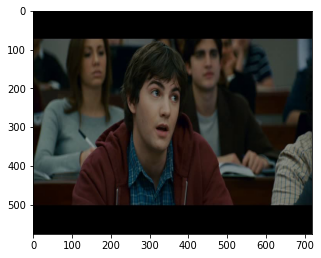

<Figure size 360x360 with 0 Axes>

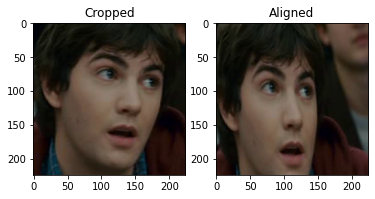

<Figure size 360x360 with 0 Axes>

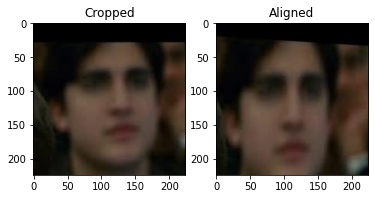

<Figure size 360x360 with 0 Axes>

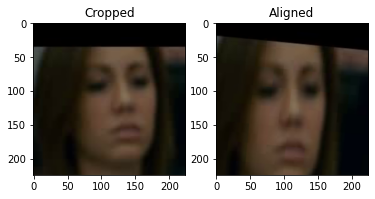

In [9]:
import matplotlib.pyplot as plt
fpath='/home/HDD6TB/datasets/emotions/EmotiW/AFEW/val/AlignedFaces_LBPTOP_Points_Val/frames/001404920/001.png'
#fpath='/home/HDD6TB/datasets/emotions/EmotiW/AFEW/val/AlignedFaces_LBPTOP_Points_Val/frames/010255520/017.png'
#fpath='/home/HDD6TB/datasets/emotions/EmotiW/AFEW/val/AlignedFaces_LBPTOP_Points_Val/frames/012705800/030.png'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    #face_img=frame[y1:y2,x1:x2,:]

    #face_img=extract_image_chip(frame,p)
    p = p.reshape((2,5)).T
        
    plt.figure(figsize=(5, 5))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    face_img=preprocess(frame,box,None) #p)
    ax1.set_title('Cropped')
    ax1.imshow(face_img)
    
    face_img=preprocess(frame,box,p)
    ax2.set_title('Aligned')
    ax2.imshow(face_img)

In [5]:
def save_aligned_faces(source_path,save_path):
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.mkdir(os.path.join(save_path, folder))

            prev_b = None
            counter = 0

            for image in sorted(os.listdir(os.path.join(source_path, folder))):
                filename = os.path.join(source_path, folder, image)
                frame = cv2.imread(filename)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                bounding_boxes, points = imgProcessing.detect_faces(frame)
                points = points.T

                best_ind=None
                if len(bounding_boxes)==0:
                    print('No faces found for ',filename)
                    counter+=1
                    if prev_b is None or counter>3:
                        continue
                    else:
                        b=prev_b
                elif len(bounding_boxes)>1:
                    print('Too many faces (',len(bounding_boxes),') found for ',filename)
                    if prev_b is None:
                        #continue
                        best_ind=0
                        b=[int(bi) for bi in bounding_boxes[best_ind]]
                        counter=0
                    else:
                        best_iou=0
                        for i in range(len(bounding_boxes)):
                            iou=get_iou(bounding_boxes[i],prev_b)
                            if iou>best_iou:
                                best_iou=iou
                                best_ind=i
                        if best_iou>0:
                            b=[int(bi) for bi in bounding_boxes[best_ind]]
                            print('best_iou (',best_iou,') best_bb ',bounding_boxes[best_ind])
                        else:
                            #continue
                            best_ind=0
                            b=[int(bi) for bi in bounding_boxes[best_ind]]
                            counter=0
                else:
                    best_ind=0
                    b=[int(bi) for bi in bounding_boxes[best_ind]]
                    counter=0
                prev_b=b

                if True:
                    p=None
                    if best_ind is not None:
                        p=points[best_ind]
                        if True: #not USE_RETINA_FACE:
                            p = p.reshape((2,5)).T
                    face_img=preprocess(frame,b,None) #p)
                else:
                    x1,y1,x2,y2=b[0:4]
                    face_img=frame[y1:y2,x1:x2,:]
                if np.prod(face_img.shape)==0:
                    print('Empty face ',b,' found for ',filename)
                    continue

                cv2.imwrite(os.path.join(save_path, folder, image), cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR)) 

#aligned
save_aligned_faces(os.path.join(DATA_DIR,'val/AlignedFaces_LBPTOP_Points_Val/frames/'),os.path.join(DATA_DIR,'val/AlignedFaces_LBPTOP_Points_Val/frames_mtcnn_cropped/'))
save_aligned_faces(os.path.join(DATA_DIR,'train/AlignedFaces_LBPTOP_Points/frames/'),os.path.join(DATA_DIR,'train/AlignedFaces_LBPTOP_Points/frames_mtcnn_cropped/'))


#### Dlib

In [ ]:
import dlib

detector = dlib.get_frontal_face_detector()

source_path = "/home/kdemochkin/emotions/train/AlignedFaces_LBPTOP_Points/frames/"
save_path = "/home/kdemochkin/emotions/train/AlignedFaces_LBPTOP_Points/frames_dlib/"
INPUT_SIZE = (224, 224)

for folder in tqdm(os.listdir(source_path)):
    if not os.path.exists(os.path.join(save_path, folder)):
        os.mkdir(os.path.join(save_path, folder))

        for image in sorted(os.listdir(os.path.join(source_path, folder))):
            filename = os.path.join(source_path, folder, image)
            frame = cv2.imread(filename)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces,scores, idx = detector.run(gray,1,-1)
            bounding_boxes=[[face.left(),face.top(),face.right(),face.bottom()] for face in faces]

            if len(bounding_boxes)==0:
                print('No faces found for ',filename)
                face_img = frame
                    
            elif len(bounding_boxes)>1:
                print('Too many faces (',len(bounding_boxes),') found for ',filename)
                bounding_boxes=bounding_boxes[:1]
                
                b=[int(bi) for bi in bounding_boxes[0]]
                x1,y1,x2,y2=b[0:4]
                face_img=frame[y1:y2,x1:x2,:]
                
                if np.prod(face_img.shape)==0:
                    print('Empty face ',b,' found for ',filename)
                    continue
            
            else:
                print('One face found for ', filename)
                b=[int(bi) for bi in bounding_boxes[0]]
                x1,y1,x2,y2=b[0:4]
                face_img=frame[y1:y2,x1:x2,:]
                
                if np.prod(face_img.shape)==0:
                    print('Empty face ',b,' found for ',filename)
                    continue

            face_img=cv2.resize(face_img,INPUT_SIZE)
            cv2.imwrite(os.path.join(save_path, folder, image), cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR)) 
    else:
        print(folder)

## AffectNet features

In [11]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.models import load_model,Model

In [13]:
base_model=load_model('../models/affectnet_emotions/mobilenet_7.h5')
feature_extractor_model=Model(base_model.input,[base_model.get_layer('global_pooling').output,base_model.get_layer('feats').output,base_model.output])
feature_extractor_model.summary()
_,w,h,_=feature_extractor_model.input.shape
print(w,h)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [15]:
def mobilenet_preprocess_input(x,**kwargs):
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x

preprocessing_function=mobilenet_preprocess_input

In [17]:
def get_features_scores(data_dir):
    filename2features={}
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,filename)
        X_global_features,X_feats,X_scores,X_isface=[],[],[],[]
        imgs=[]
        for img_name in os.listdir(frames_dir):
            img=cv2.imread(os.path.join(frames_dir,img_name))
            X_isface.append('noface' not in img_name)
                
            if img.size:
                img=cv2.resize(img,(w,h))
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                imgs.append(img)
                if len(imgs)>=512:        
                    inp = preprocessing_function(np.array(imgs, dtype=np.float32))
                    global_features,feats,scores=feature_extractor_model.predict(inp)
                    #print(global_features.shape,feats.shape,scores.shape)
                    if len(X_feats)==0:
                        X_feats=feats
                        X_global_features=global_features
                        X_scores=scores
                    else:
                        X_feats=np.concatenate((X_feats,feats),axis=0)
                        X_global_features=np.concatenate((X_global_features,global_features),axis=0)
                        X_scores=np.concatenate((X_scores,scores),axis=0)
                    
                    imgs=[]

        if len(imgs)>0:        
            inp = preprocessing_function(np.array(imgs, dtype=np.float32))
            global_features,feats,scores=feature_extractor_model.predict(inp)
            #print(global_features.shape,feats.shape,scores.shape)
            if len(X_feats)==0:
                X_feats=feats
                X_global_features=global_features
                X_scores=scores
            else:
                X_feats=np.concatenate((X_feats,feats),axis=0)
                X_global_features=np.concatenate((X_global_features,global_features),axis=0)
                X_scores=np.concatenate((X_scores,scores),axis=0)

        X_isface=np.array(X_isface)
        #print(X_global_features.shape,X_feats.shape,X_scores.shape)
        filename2features[filename]=(X_global_features,X_feats,X_scores,X_isface)
    return filename2features

#filename2Allfeatures_val=get_features_scores(os.path.join(DATA_DIR,'val/AlignedFaces_LBPTOP_Points_Val/frames_mtcnn_cropped/'))
filename2Allfeatures_train=get_features_scores(os.path.join(DATA_DIR,'train/AlignedFaces_LBPTOP_Points/frames_mtcnn_cropped/')) #_cropped

100%|██████████| 773/773 [03:57<00:00,  3.26it/s]


### Save/load features 

In [ ]:
#model_name='mobilenet_v1_ft'
model_name='mymobilenet_7_ft_sgd_model'
MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw.pickle' #'_feat_bgr_emotiw.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'scores_emotiw.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw_aligned.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw_cropped.pickle'

#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_emotiw.pickle'
print(MODEL2EMOTIW_FEATURES)

In [12]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    #pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump([filename2Allfeatures_train,filename2Allfeatures_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
if False:
    with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
        filename2features_train,filename2features_val=pickle.load(handle)
    print(len(filename2features_train),len(filename2features_val))
else:
    with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
        filename2Allfeatures_train,filename2Allfeatures_val=pickle.load(handle)
    print(len(filename2Allfeatures_train),len(filename2Allfeatures_val))

773 383


In [36]:
USE_ALL_FEATURES=True
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for category in emotion_to_index:
        for filename in os.listdir(os.path.join(data_dir,category)):
            fn=os.path.splitext(filename)[0]
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            if USE_ALL_FEATURES and True:
                for face in [1,0]:
                    cur_features=features[ind][features[-1]==face]
                    if len(cur_features)==0:
                        continue
                    weight=len(cur_features)/len(features[ind])
                    mean_features = np.mean(cur_features, axis=0)
                    std_features = np.std(cur_features, axis=0)
                    max_features = np.max(cur_features, axis=0)
                    min_features = np.min(cur_features, axis=0)

                    # join several features together
                    feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                    #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                    #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                    #feature=mean_features
                    #feature=max_features

                    if total_features is None:
                        total_features=weight*feature
                    else:
                        total_features+=weight*feature
                has_faces.append(1)
            else:
                if USE_ALL_FEATURES:
                    cur_features=features[0][features[-1]==1]
                else:
                    cur_features=features
                if len(cur_features)==0:
                    has_faces.append(0)
                    total_features=np.zeros_like(feature)
                else:
                    has_faces.append(1)
                    #mean_features=features.mean(axis=0)
                    mean_features = np.mean(cur_features, axis=0)
                    std_features = np.std(cur_features, axis=0)
                    max_features = np.max(cur_features, axis=0)
                    min_features = np.min(cur_features, axis=0)

                    # join several features together
                    feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                    #feature = np.concatenate((mean_features, std_features, max_features), axis=None)
                    #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                    #feature = np.concatenate((mean_features, std_features), axis=None)
                    #feature = np.concatenate((max_features, std_features), axis=None)
                    #feature=max_features
                    #feature=mean_features
                    #feature=cur_features[-1]
                    #feature=np.percentile(cur_features, 100,axis=0)

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[category])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces


if USE_ALL_FEATURES:
    x_train, y_train, has_faces_train = create_dataset(filename2Allfeatures_train,os.path.join(DATA_DIR,'train'))
    x_test, y_test, has_faces_test = create_dataset(filename2Allfeatures_val,os.path.join(DATA_DIR,'val'))
else:
    x_train, y_train, has_faces_train = create_dataset(filename2features_train,os.path.join(DATA_DIR,'train'))
    x_test, y_test, has_faces_test = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'))

(773, 4096) (773,)
(383, 4096) (383,)


In [37]:
if True:
    x_train_norm=preprocessing.normalize(x_train,norm='l2')
    x_test_norm=preprocessing.normalize(x_test,norm='l2')
else:
    # standartize features
    scaler = preprocessing.StandardScaler()
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)

In [38]:
#clf = svm.LinearSVC(C=0.07)
#clf = svm.SVC(kernel='rbf')
np.random.seed(1)
clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=9,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
elif False:
    clf.fit(preprocessing.normalize(x_train[has_faces_train==1],norm='l2'), y_train[has_faces_train==1])
    y_pred = clf.predict(preprocessing.normalize(x_test,norm='l2'))
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5535248041775457
Complete accuracy: 0.5535248041775457
